In [1]:
import sys
sys.path.insert(0, "../") # am ashame

import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import yaml

import npm_utils as npm
import stan_utils as stan
from mpl_utils import mpl_style

plt.style.use(mpl_style)

%matplotlib inline

In [2]:
base_path = "../"
with open(os.path.join(base_path, npm.CONFIG_PATH), "r") as fp:
    config = yaml.load(fp)
config["model_path"] = "../npm.stan"
config

{'data_path': 'data/rv-all-subset-1e4.fits',
 'kdtree_label_names': ['bp_rp', 'absolute_rp_mag', 'phot_rp_mean_mag'],
 'kdtree_minimum_points': 128,
 'kdtree_minimum_radius': [0.05, 0.25, 0.25],
 'kdtree_relative_scales': [0.1, 1.0, 1.0],
 'model_path': '../npm.stan',
 'optimisation_kwds': {'iter': 10000,
  'tol_grad': '1e-15',
  'tol_obj': '1e-15',
  'tol_rel_grad': '1e3',
  'tol_rel_obj': '1e4',
  'verbose': False},
 'predictor_label_names': ['rv_single_epoch_scatter'],
 'results_path': 'results/',
 'results_suffix': None,
 'share_optimised_result_with_nearest': 8}

In [3]:
with open(config["model_path"], "r") as fp:
    model_code = fp.readlines()

print("".join(model_code))

data {
    int<lower=1> N; // number of data points
    int<lower=1> D; // number of dimensions
    real y[N, D]; // the data points.
}

parameters {
    real<lower=0,upper=1> theta; // the mixing parameter
    real<lower=0> mu_single[D]; // single star distribution mean
    real<lower=0> sigma_single[D]; // single star distribution sigma
    real<lower=0> sigma_multiple[D]; // multiplcity log-normal distribution sigma
    real<lower=0, upper=1> mu_multiple_uv[D]; // unit vector of the multiplicity log-normal distribution mean
}

transformed parameters {
    real mu_multiple[D];

    for (d in 1:D) {
        real var_multiple;
        real bound_lower;
        real bound_upper;
        var_multiple = pow(sigma_multiple[d], 2);
        bound_lower = log(mu_single[d]);
        bound_upper = log(mu_single[d] + 5 * sigma_single[d]);
        mu_multiple[d] = bound_lower + var_multiple
                       + mu_multiple_uv[d] * (bound_upper - bound_lower);
    }

}

model {

    theta ~ be

In [4]:
# Relevant configuration keywords:
#   kdtree_label_names     - label names to use to construct the KD tree
#   kdtree_relative_scales - scale the dimensions when constructing the KD tree
#   kdtree_minimum_points  - minimum number of points to have when querying the KD tree
#   kdtree_minimum_radius  - minimum ball radius (in each dimension) when querying the KD tree


In [5]:
from astropy.io import fits
data = fits.open(os.path.join(base_path, config["data_path"]))[1].data

In [6]:
X = np.vstack([data[ln] for ln in config["kdtree_label_names"]]).T
predictors = np.vstack([data[ln] for ln in config["predictor_label_names"]]).T

finite = np.where(np.all(np.isfinite(X), axis=1))[0]

X = X[finite]
predictors = predictors[finite]

N, D = X.shape

kdt, scale, offset = npm.build_kdtree(
    X, relative_scales=config.get("kdtree_relative_scales", None))

query_kwds = dict(offset=offset, scale=scale, full_output=False,
                  minimum_points=config.get("kdtree_minimum_points", 1024),
                  minimum_radius=config.get("kdtree_minimum_radius", None))
print(query_kwds)

{'offset': array([ 1.03375229,  2.53939978, 11.16616161]), 'scale': [0.1, 1.0, 1.0], 'full_output': False, 'minimum_points': 128, 'minimum_radius': [0.05, 0.25, 0.25]}


Text(0,0.5,'\\textrm{absolute rp mag}')

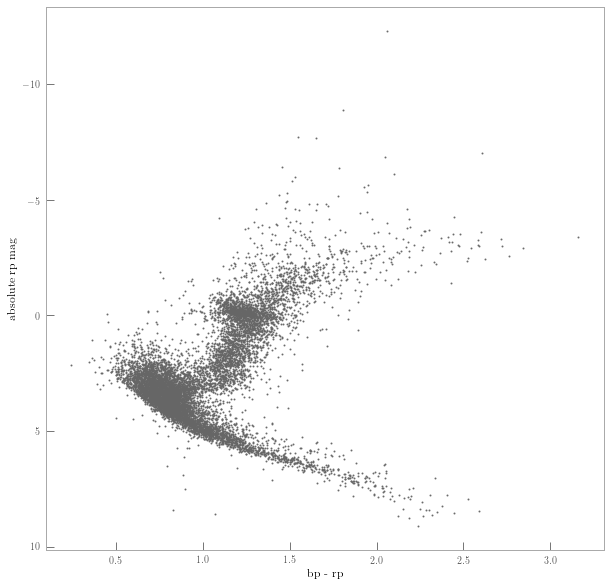

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(X.T[0], X.T[1], s=1, c="#666666", alpha=0.9)
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xlabel(r"\textrm{bp - rp}")
ax.set_ylabel(r"\textrm{absolute rp mag}")

## We are doing these tests with a random subset of ~10,000 stars

In [8]:
import warnings
warnings.filterwarnings("ignore") # shhhhhh

norm_pdf = lambda x, mu, sigma: (2 * np.pi * sigma**2)**(-0.5) * np.exp(-(x - mu)**2/(2*sigma**2))
lognorm_pdf = lambda x, mu, sigma: 1.0/(x * sigma * np.sqrt(2*np.pi)) \
                                 * np.exp(-0.5 * ((np.log(x) - mu)/sigma)**2)

scatter_bg_kwds = dict(s=1, c="#666666", alpha=0.9)
scatter_ball_kwds = dict(s=10, c="tab:red", zorder=5, alpha=0.9)
scatter_point_kwds = dict(s=20, c="#000000", zorder=10, alpha=1)
hist_kwds = dict(facecolor="tab:red", bins=50)
axvline_kwds = dict(zorder=10, c="#000000")

matplotlib.rcParams["figure.max_open_warning"] = 1000

INFO:root:Using pre-compiled model from ../npm.stan.cached


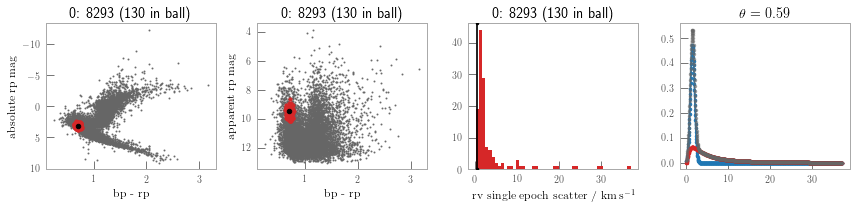

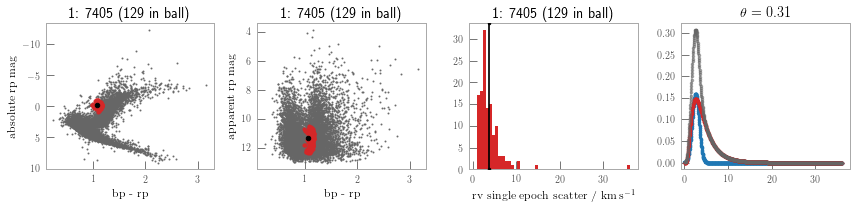

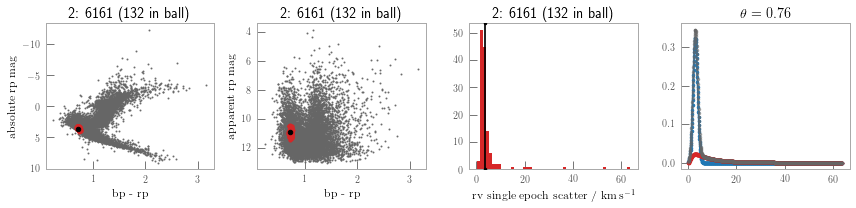

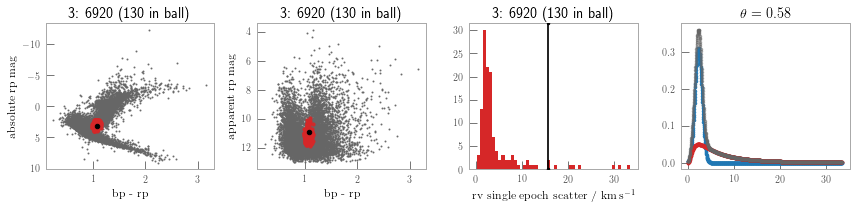

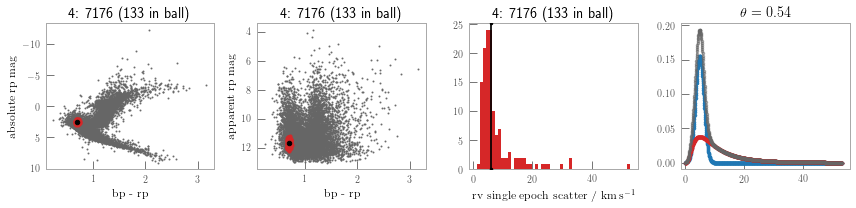

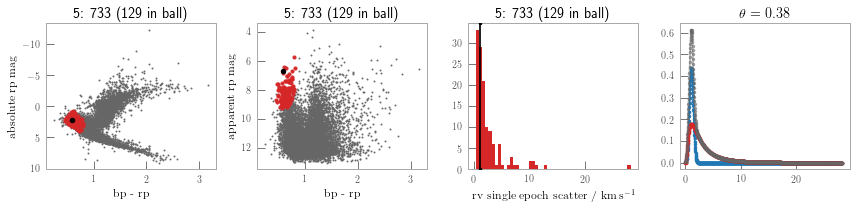

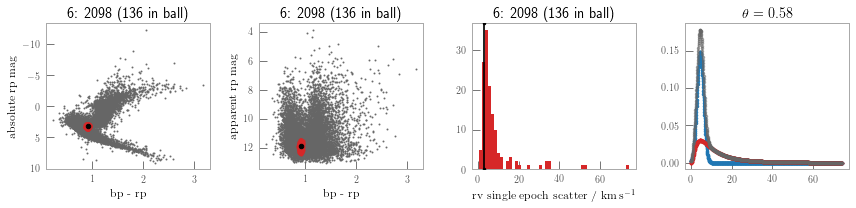

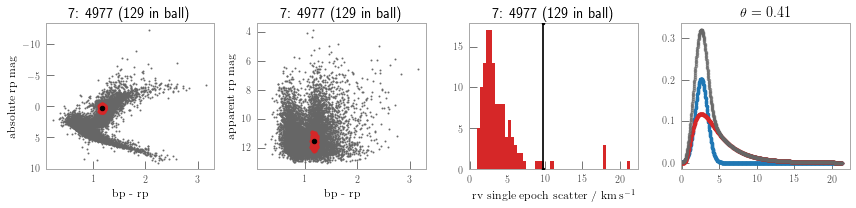

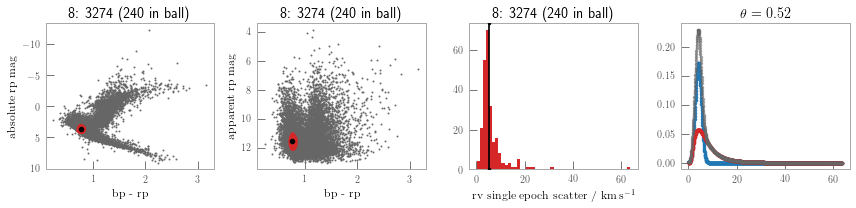

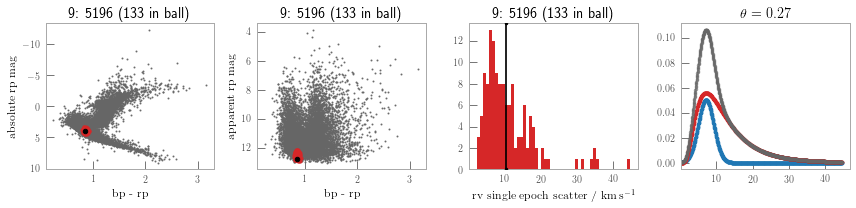

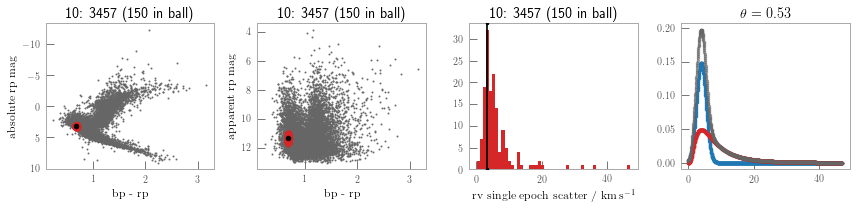

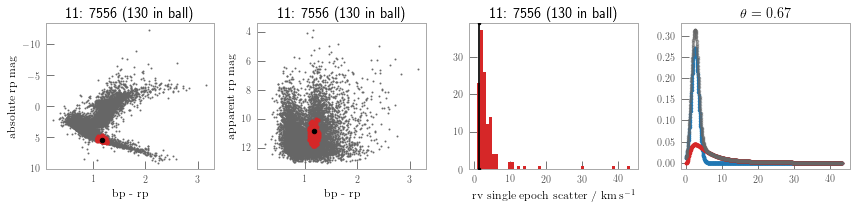

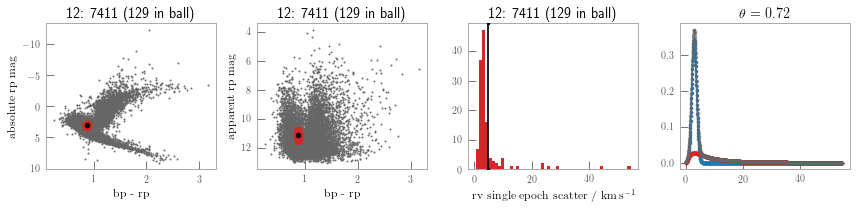

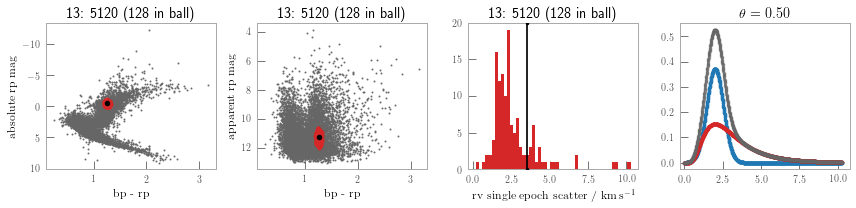

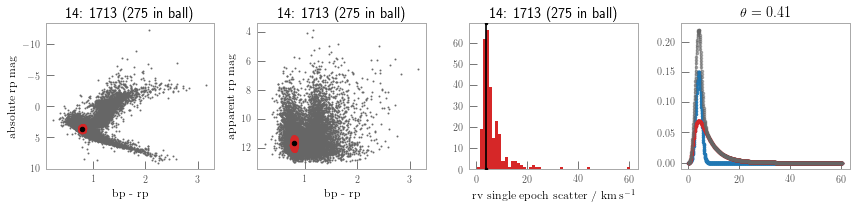

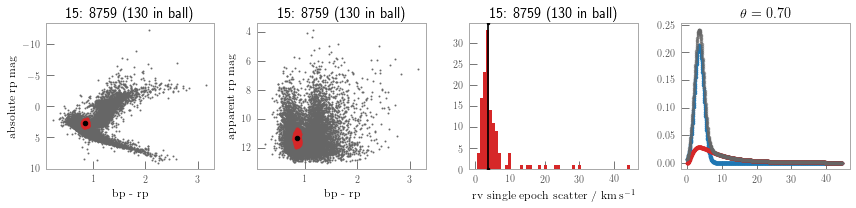

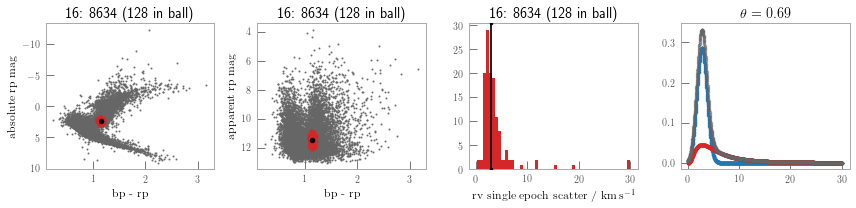

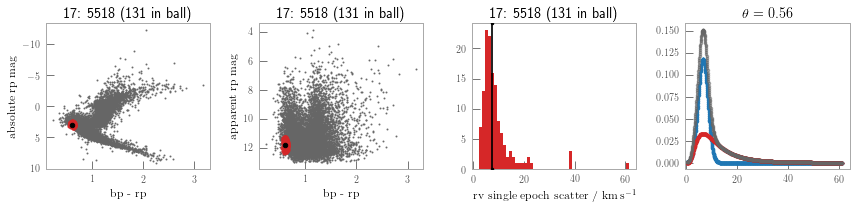

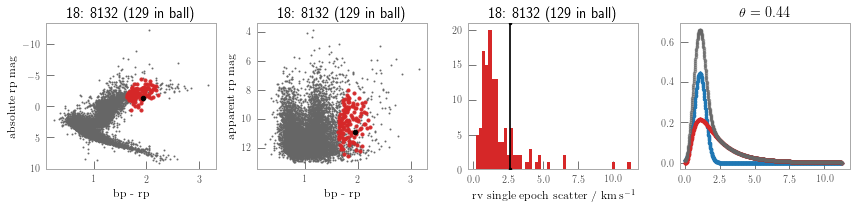

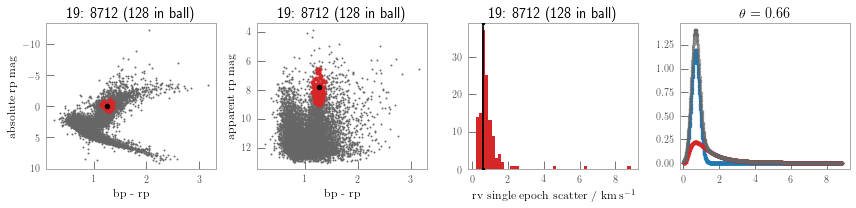

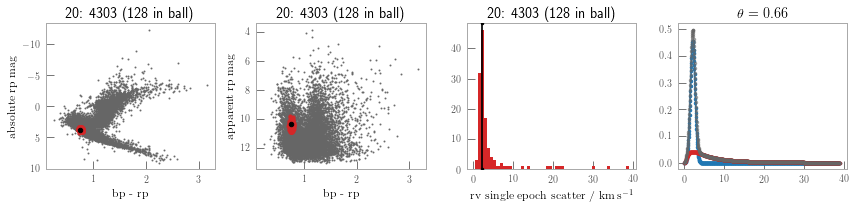

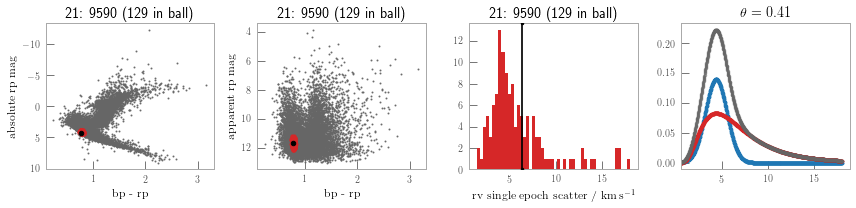

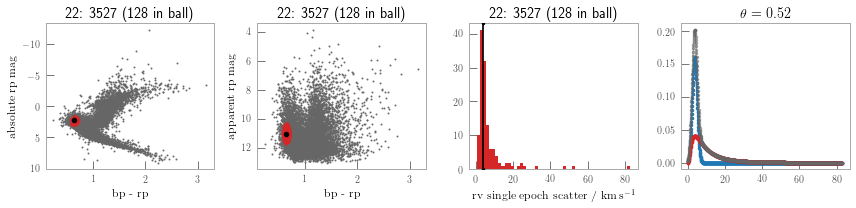

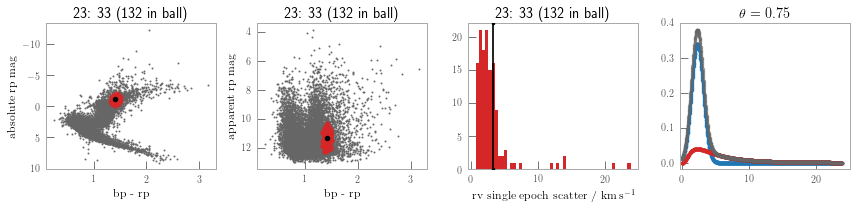

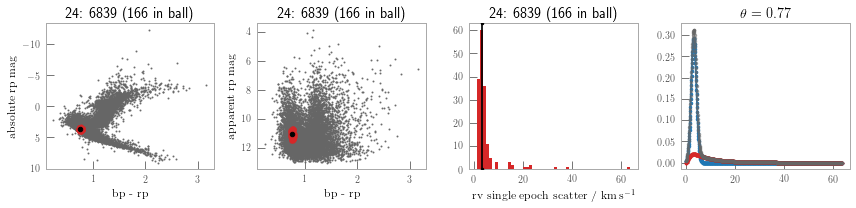

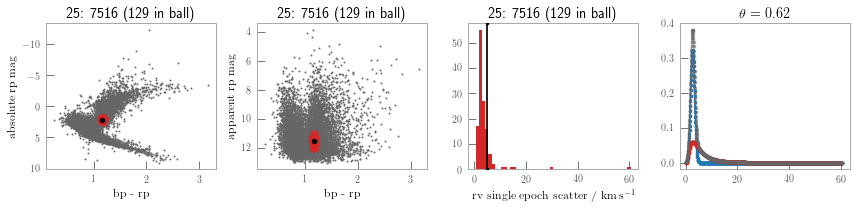

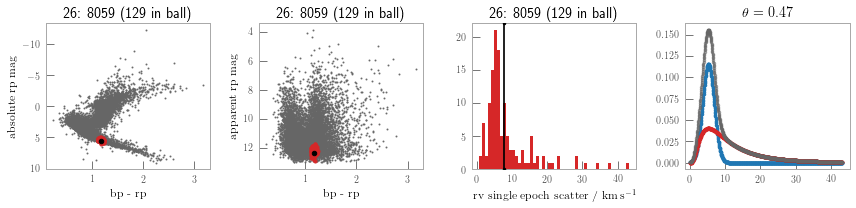

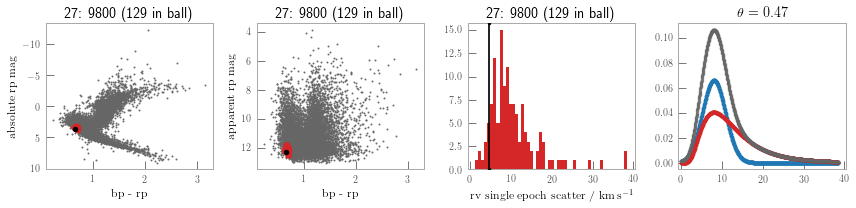

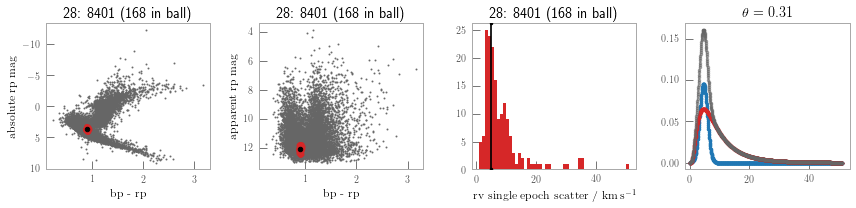

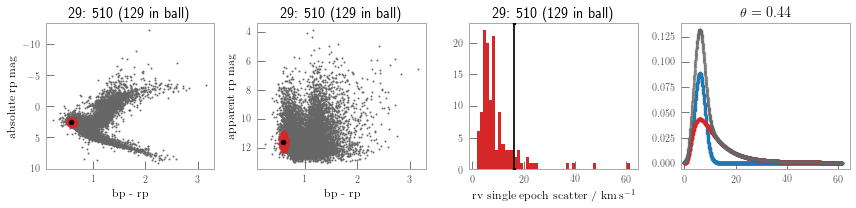

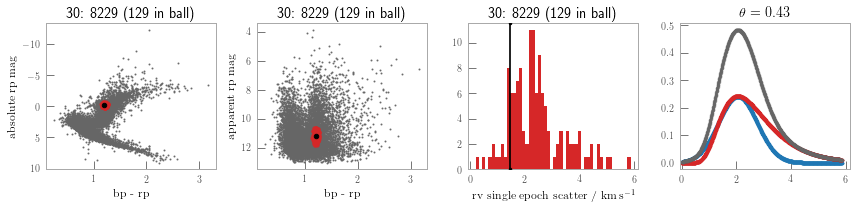

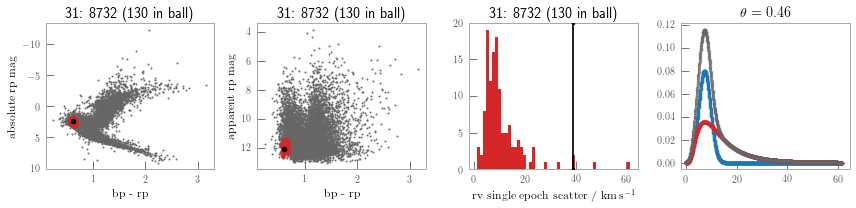

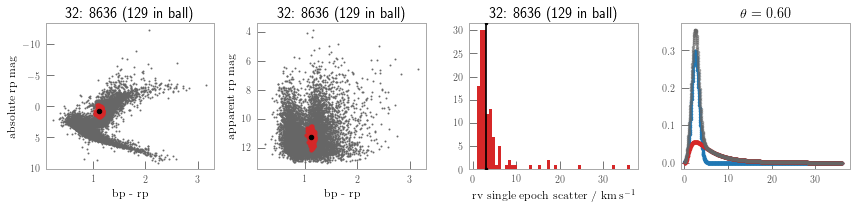

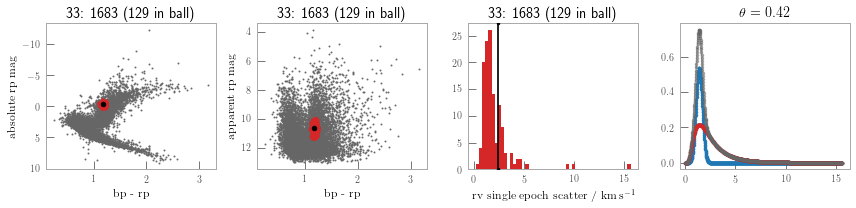

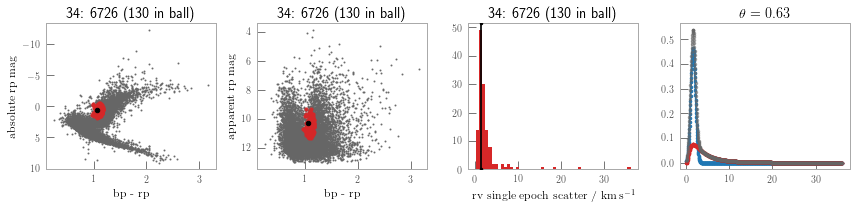

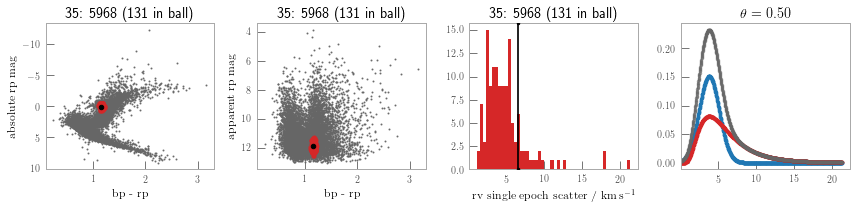

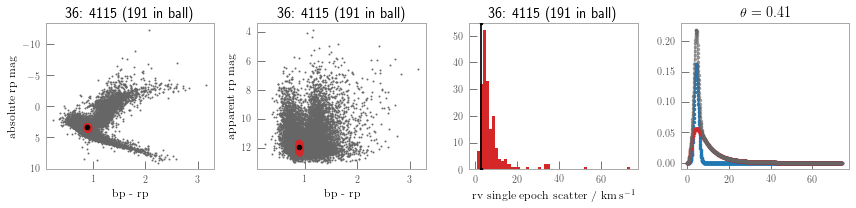

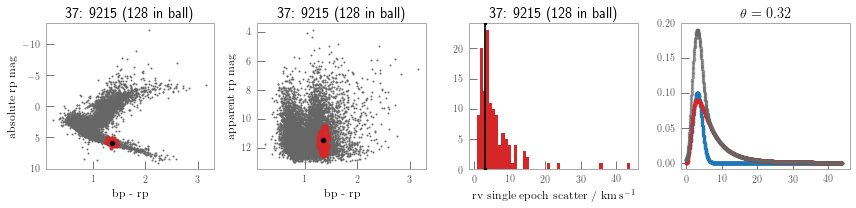

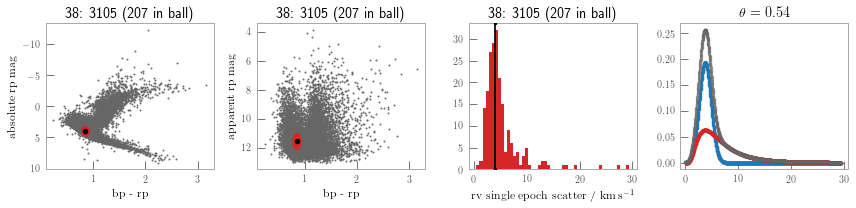

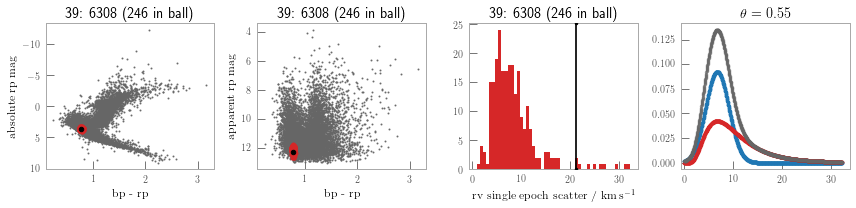

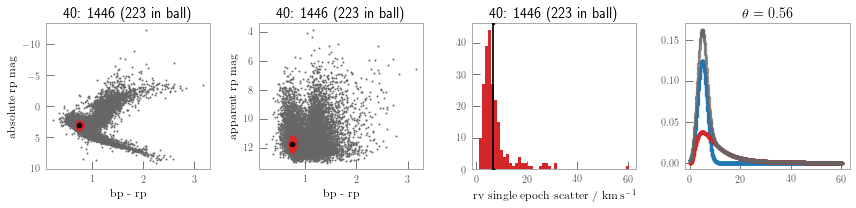

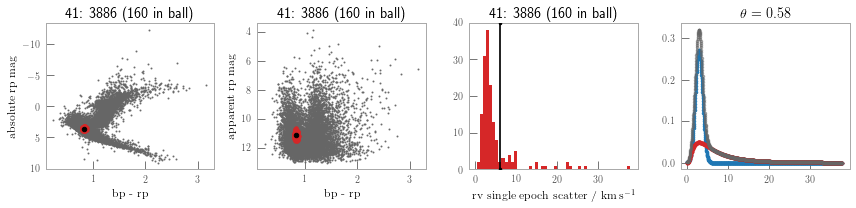

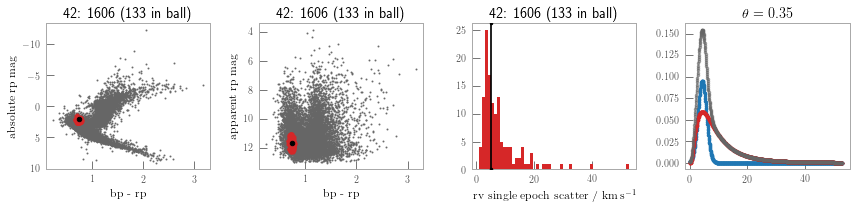

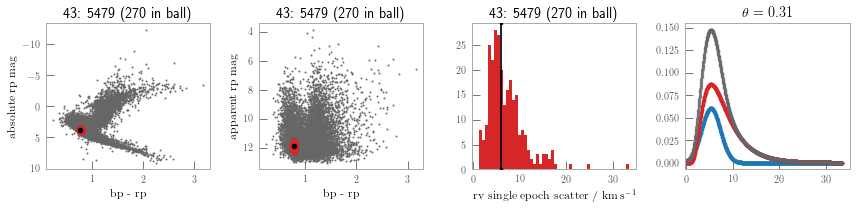

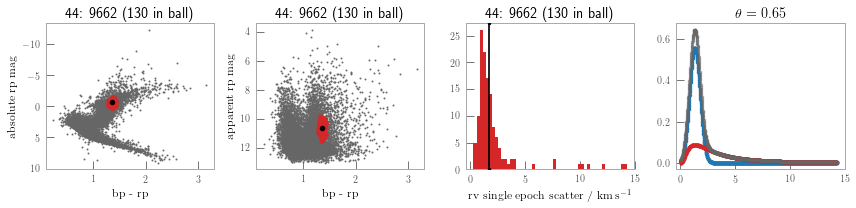

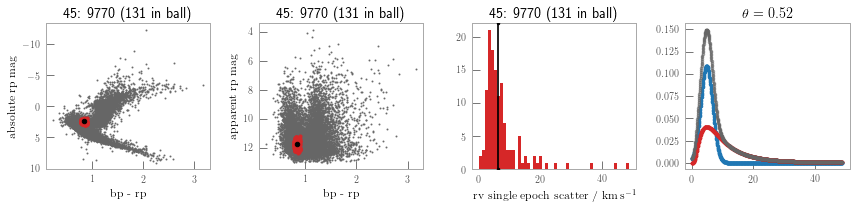

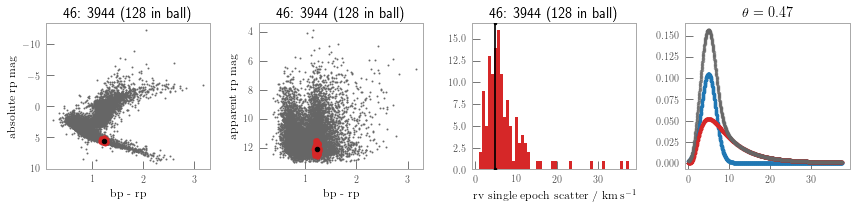

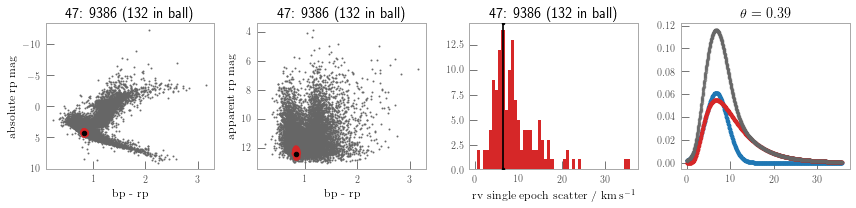

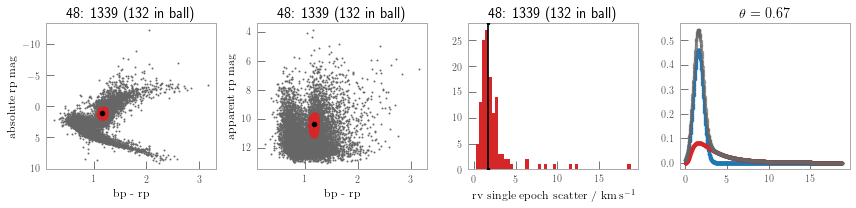

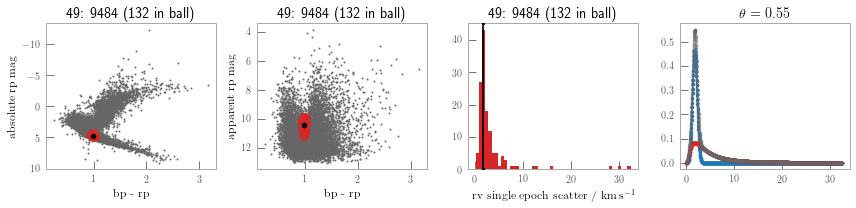

In [9]:
np.random.seed(42)

P = 50

model = stan.load_stan_model(config["model_path"])

previous_opt = []

for i, index in enumerate(np.random.choice(N, P, replace=False)):
    
    K = 4
    fig, axes = plt.subplots(1, K, figsize=(3*K, 3))
    
    axes[0].scatter(X.T[0], X.T[1], **scatter_bg_kwds)
    
    nearby = npm.query_around_point(kdt, X[index], **query_kwds)
    axes[0].scatter(X[nearby, 0], X[nearby, 1], **scatter_ball_kwds)
    axes[0].scatter(X[[index], 0], X[[index], 1], **scatter_point_kwds)
    
    axes[0].set_xlabel(r"\textrm{bp - rp}")
    axes[0].set_ylabel(r"\textrm{absolute rp mag}")
    axes[0].set_ylim(axes[0].get_ylim()[::-1])
    
    axes[1].scatter(X.T[0], X.T[2], **scatter_bg_kwds)
    axes[1].scatter(X[nearby, 0], X[nearby, 2], **scatter_ball_kwds)
    axes[1].scatter(X[[index], 0], X[[index], 2], **scatter_point_kwds)
    axes[1].set_xlabel(r"\textrm{bp - rp}")
    axes[1].set_ylabel(r"\textrm{apparent rp mag}")
    axes[1].set_ylim(axes[1].get_ylim()[::-1])
    
    y = predictors[nearby].flatten()
    axes[2].hist(y[np.isfinite(y)], **hist_kwds)
    axes[2].axvline(predictors[index], **axvline_kwds)
    axes[2].set_xlabel(r"\textrm{rv single epoch scatter / km\,s$^{-1}$}")
    
    y = y.reshape(-1, 1)
    N, D = y.shape
    
    opt_kwds = dict(
        init=npm.get_initialization_point(y) if i == 0 else previous_opt[-1],
        verbose=False,
        tol_obj=7./3 - 4./3 - 1, # machine precision
        tol_grad=7./3 - 4./3 - 1, # machine precision
        tol_rel_grad=1e3,
        tol_rel_obj=1e4,
        iter=10000,
        data=dict(y=y, N=N, D=D))
    
    p_opt = model.optimizing(**opt_kwds)
    
    
    xi = np.linspace(0, y.max(), 1000)
    y1 = p_opt["theta"] * norm_pdf(xi, p_opt["mu_single"], p_opt["sigma_single"])
    y2 = (1 - p_opt["theta"]) * lognorm_pdf(xi, p_opt["mu_multiple"], p_opt["sigma_multiple"])
    axes[3].plot(xi, y1, c='tab:blue',)
    axes[3].plot(xi, y2, c='tab:red')
    axes[3].plot(xi, y1 + y2, c='#666666', alpha=0.5)
    axes[3].set_xlim(axes[2].get_xlim())
    axes[3].set_title(r"$\theta = {0:.2f}$".format(p_opt["theta"]))
    for ax in axes[:-1]:
        ax.set_title("{}: {} ({} in ball)".format(i, index, nearby.size))
    
    fig.tight_layout()
    
    for k in ("mu_single", "sigma_single", "mu_multiple", 
              "sigma_multiple", "mu_multiple_uv"):
        p_opt[k] = np.atleast_1d(p_opt[k])
    previous_opt.append(p_opt)

Currently we constrain the mode of the log-normal to be between: ($\mu_{s}$ and $\mu_{s} + 5\sigma_{s}$), 
where $\mu_{m}$ and $\sigma_{m}$ indicate the mean and sigma of the log-normal and $\mu_{s}$ and $\sigma_s$ refer to the normal distribution. In some of the figures above, the mode of the log-normal is pushing up against the mean of the normal, and pushing $\theta$ to low values (e.g. see index 14).

Maybe instead we want to constrain the log-normal such that there is only a small amount of support at the mean of the normal.

The CDF of a log-normal is:

$CDF(x) = \frac{1}{2} + \frac{1}{2}\textrm{erf}\left[\frac{\log{x} - \mu_{m}}{\sqrt{2}\sigma_{m}}\right]$

So what if we said the log-normal's cumulative support at the mean of the normal must be less than 10% ($q = 0.1$)?

$0.10 > \frac{1}{2} + \frac{1}{2}\textrm{erf}\left[\frac{\log{\mu_{s}} - \mu_{m}}{\sqrt{2}\sigma_{m}}\right]$

A nice analytic approximation to the error fucntion is:

$\textrm{erf}(x) \approx \tanh\left(\sqrt{\pi}\log{2}x\right)$

And remember $\tanh^{-1}(x) = \frac{1}{2}\left[\log(1 + x) - \log(1 - x)\right]$ such that:

$\mu_{m} > \log\mu_s + \sqrt{\frac{2}{\pi}}\frac{\sigma_m}{2\log{2}}\log{9}$

Which is a simplification from: 

$\mu_m > \log\mu_s - \sqrt{\frac{2}{\pi}}\frac{\sigma_m}{2\log{2}}\left[\log{(1 + (2q - 1))} - \log{(1 - (2q - 1))}\right]$

$\mu_m > \log\mu_s + \sqrt{\frac{2}{\pi}}\frac{\sigma_m}{2\log{2}}\log{(\frac{1}{q} - 1)}$

In [14]:
config["model_path"] = "../npm-cdf-constraint.stan"
with open(config["model_path"], "r") as fp:
    model_code = fp.readlines()

print("".join(model_code))

data {
    int<lower=1> N; // number of data points
    int<lower=1> D; // number of dimensions
    real y[N, D]; // the data points.
}

parameters {
    real<lower=0,upper=1> theta; // the mixing parameter
    real<lower=0> mu_single[D]; // single star distribution mean
    real<lower=0> sigma_single[D]; // single star distribution sigma
    real<lower=0> sigma_multiple[D]; // multiplcity log-normal distribution sigma
    real<lower=0, upper=1> mu_multiple_uv[D]; // unit vector of the multiplicity log-normal distribution mean
}

transformed parameters {
    real mu_multiple[D];

    # Bound the log-normal such that at most 10% of the support is at the mean
    # of the normal.
    {
        real max_support_fraction;
        real v;
        max_support_fraction = 0.10;
        v = 2 * max_support_fraction - 1;

        for (d in 1:D) {
            real bound_lower;
            real bound_upper;
            # 0.575 ~= sqrt(2/pi)/(2log2)
            bound_lower = log(mu_single[d]) - 0.5

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_396de95e38d5ebeb7907907c8711751c NOW.


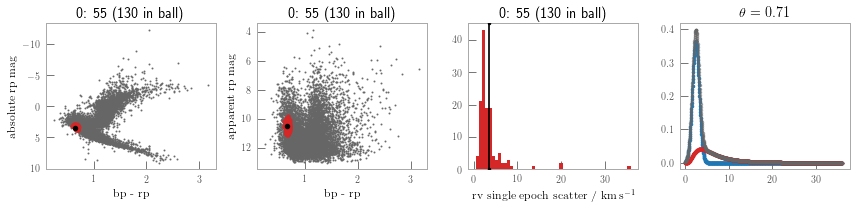

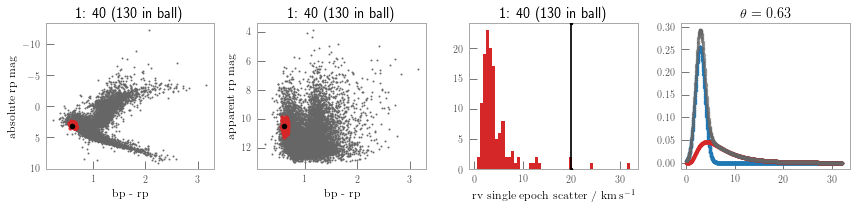

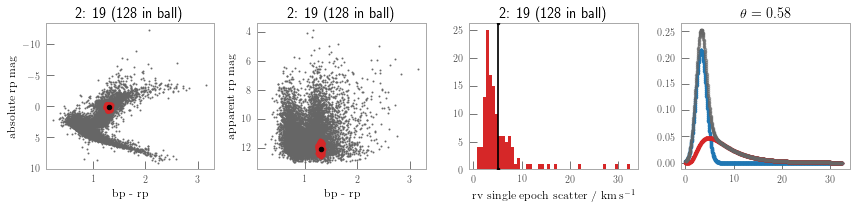

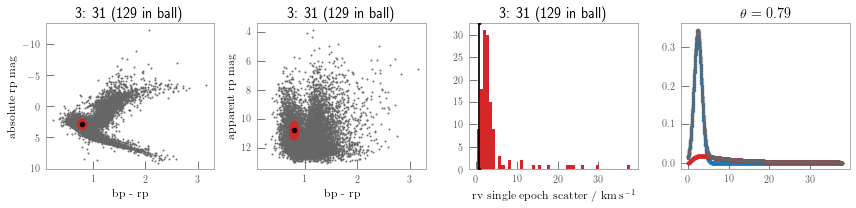

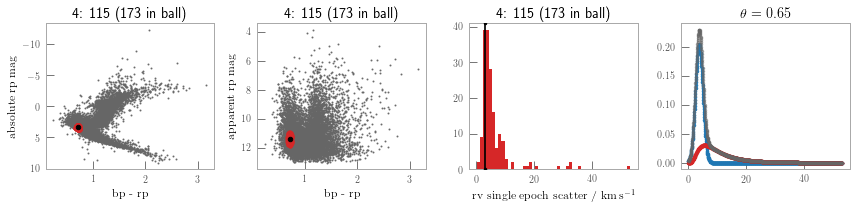

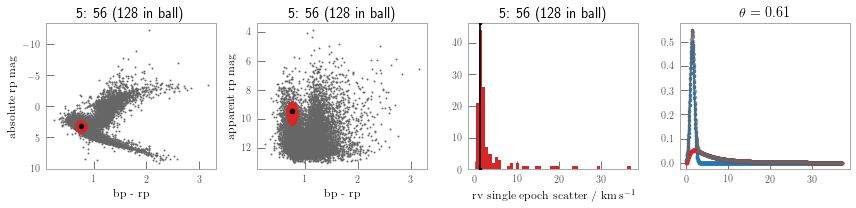

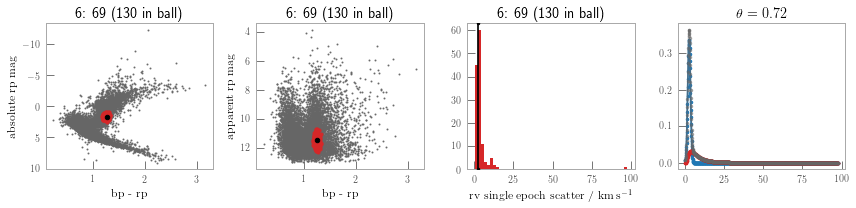

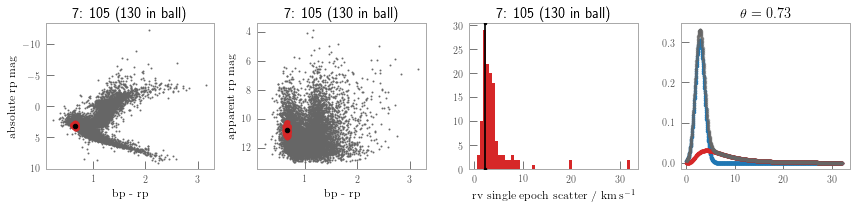

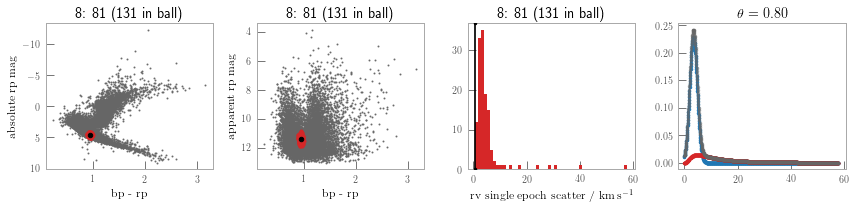

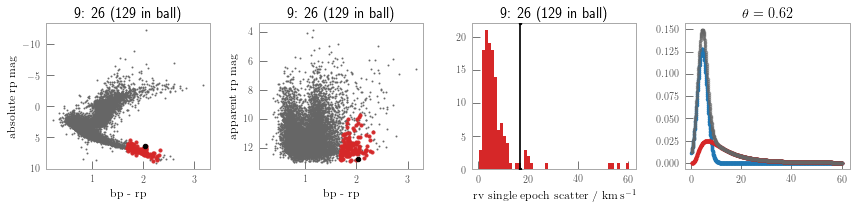

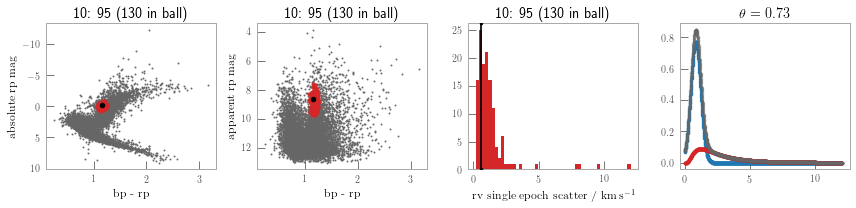

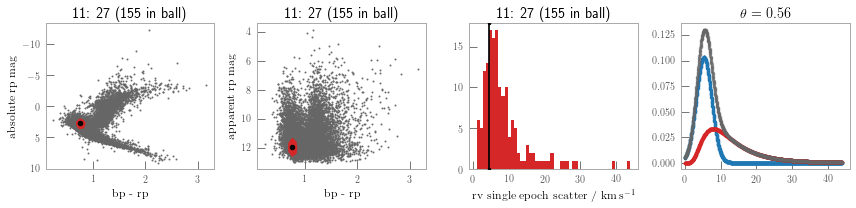

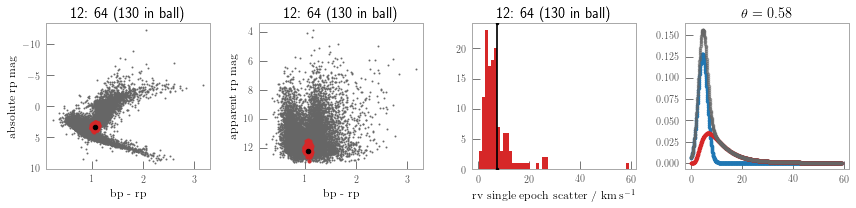

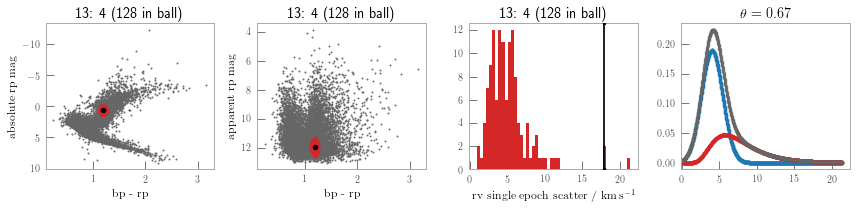

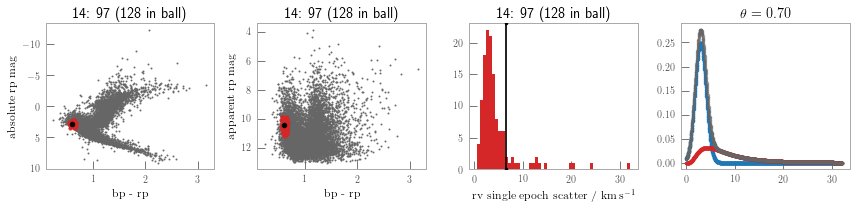

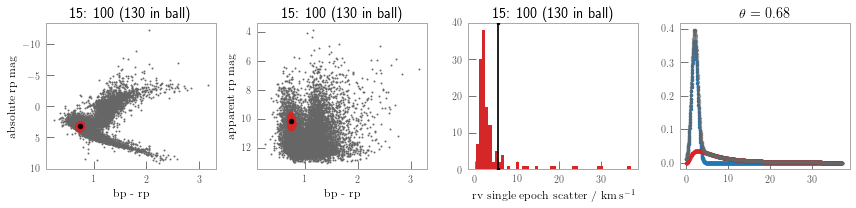

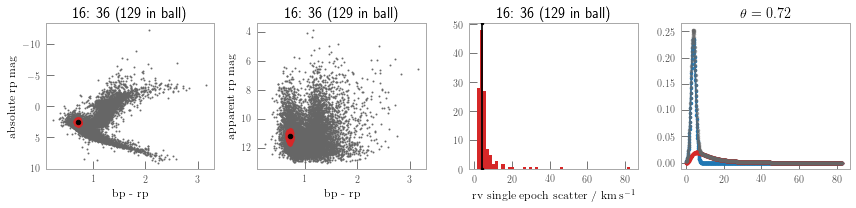

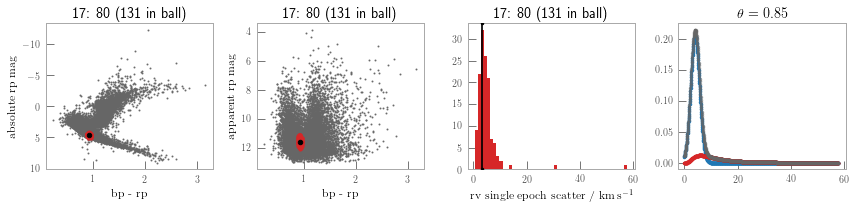

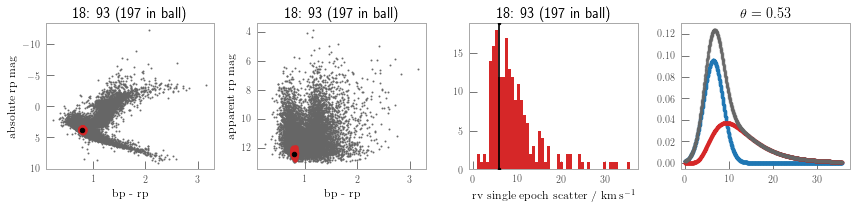

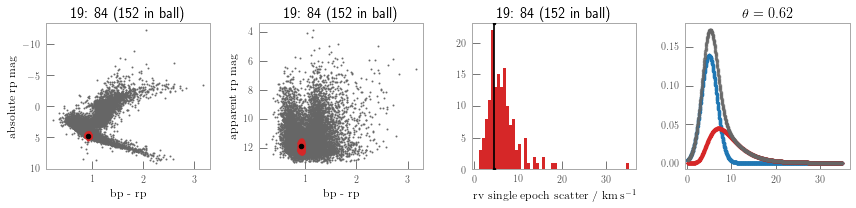

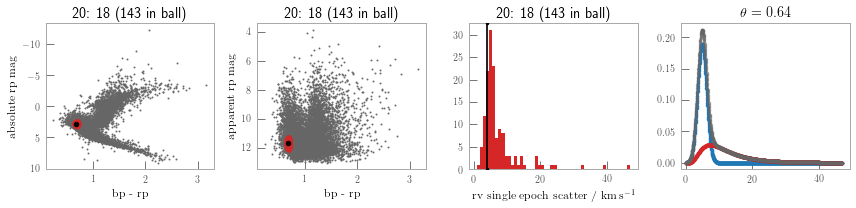

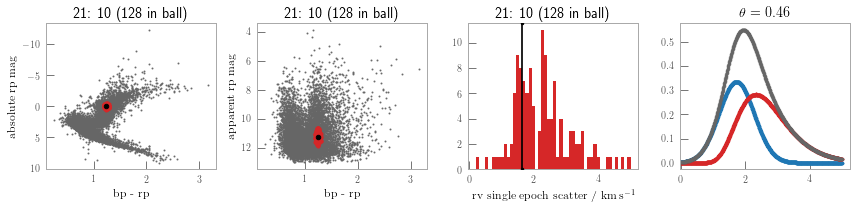

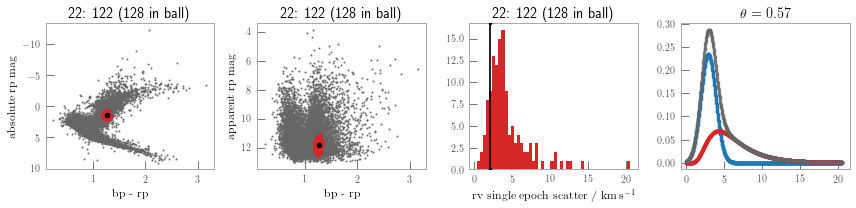

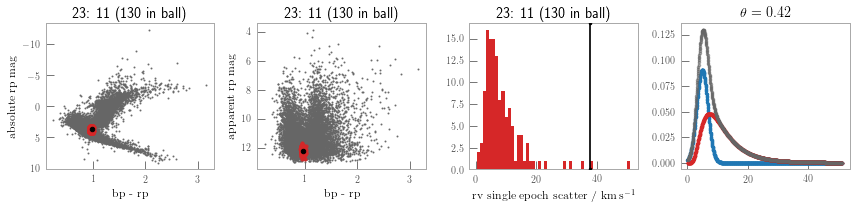

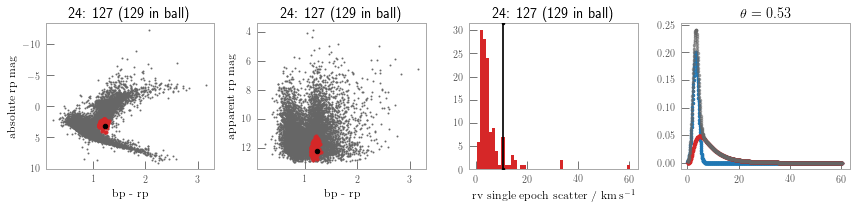

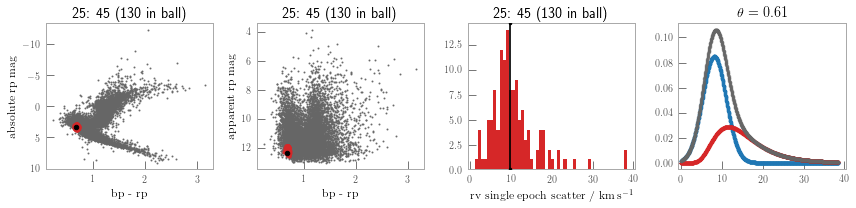

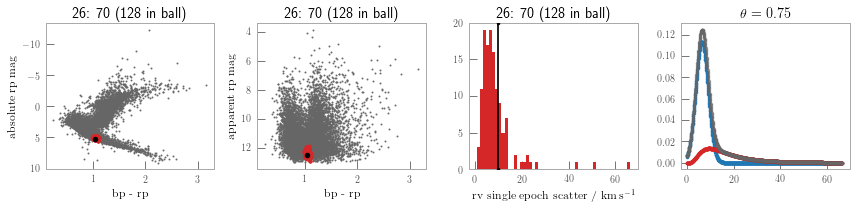

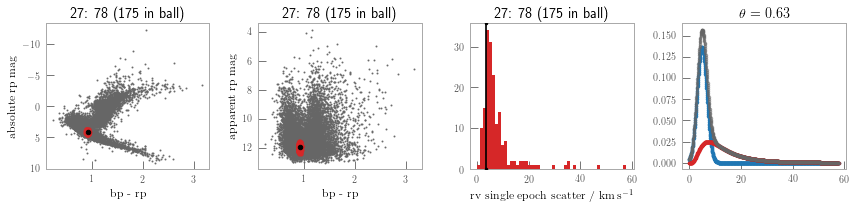

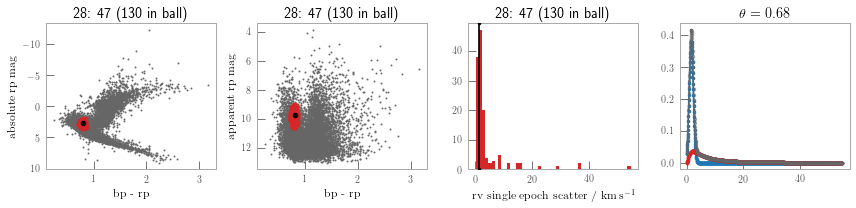

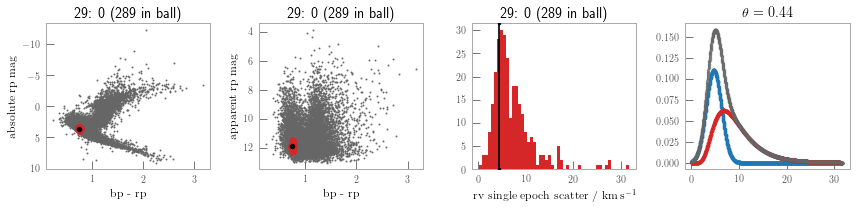

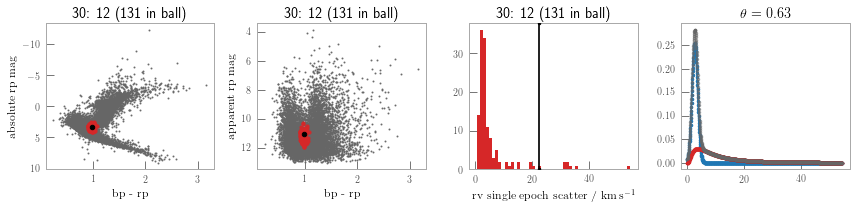

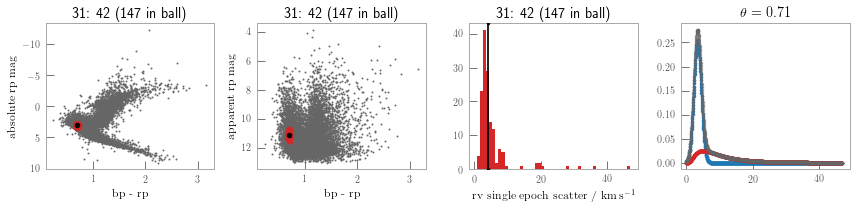

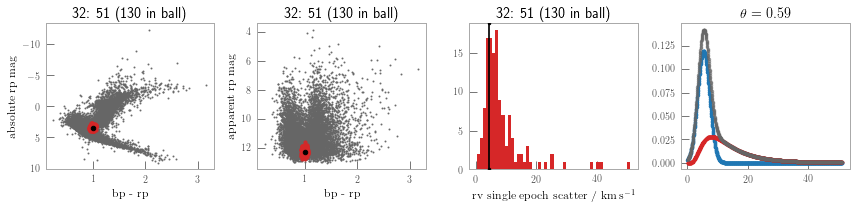

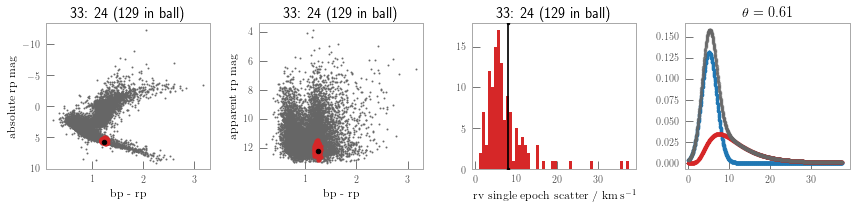

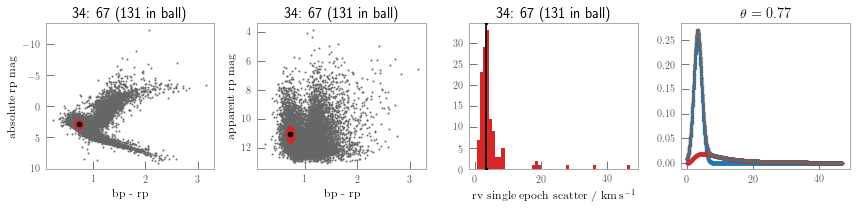

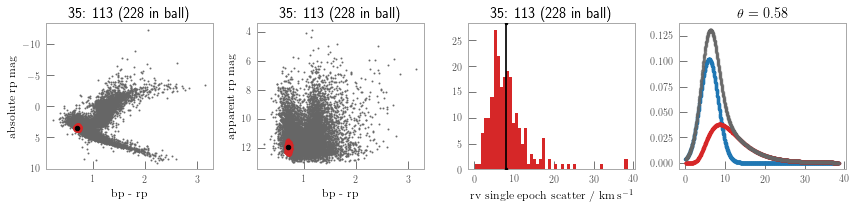

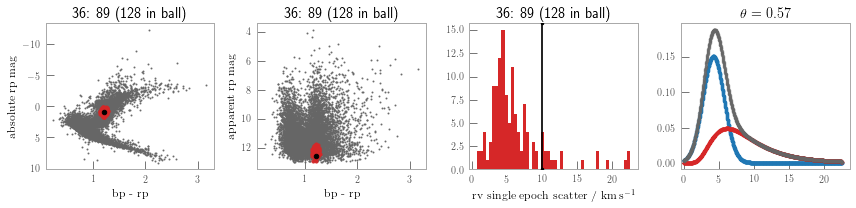

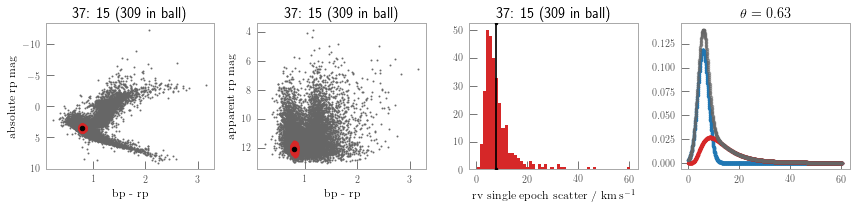

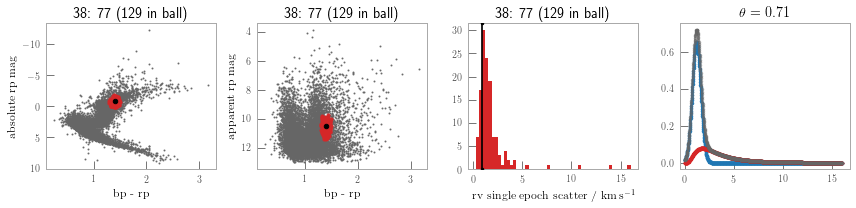

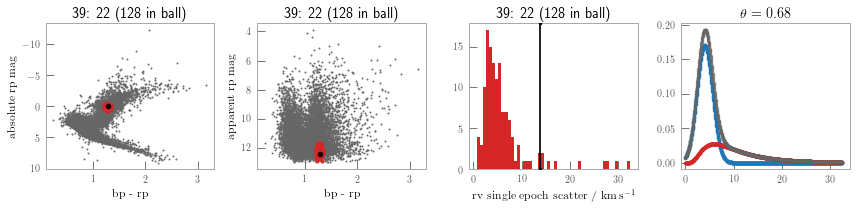

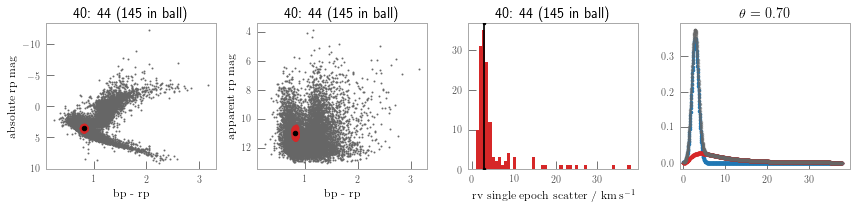

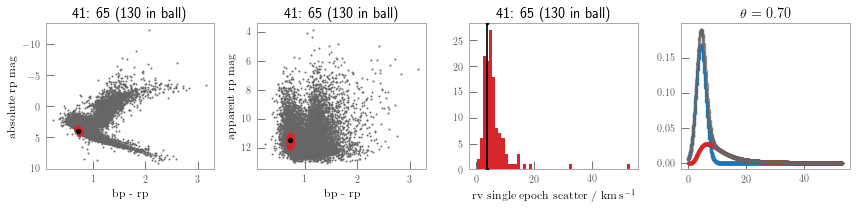

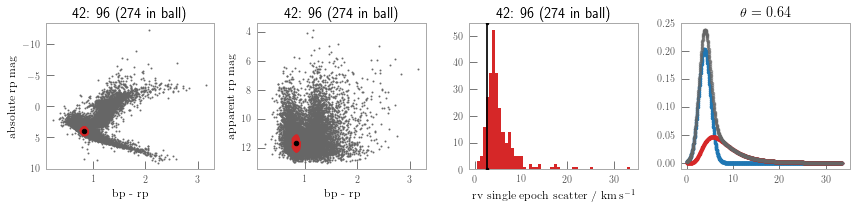

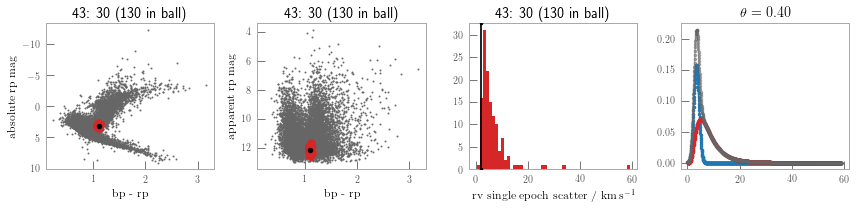

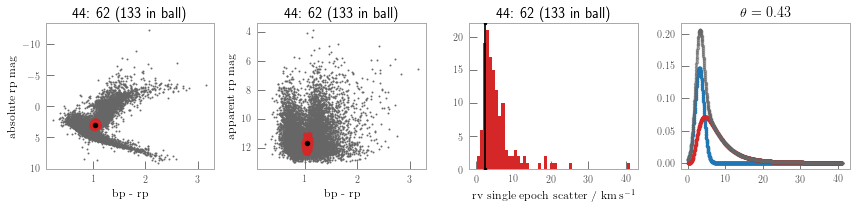

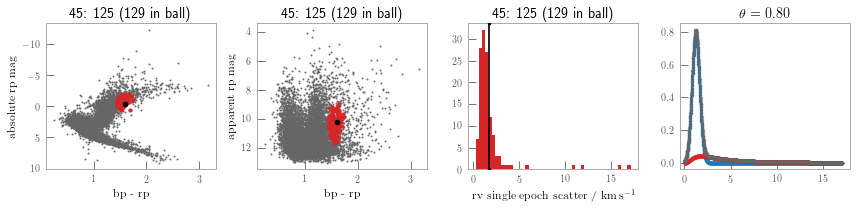

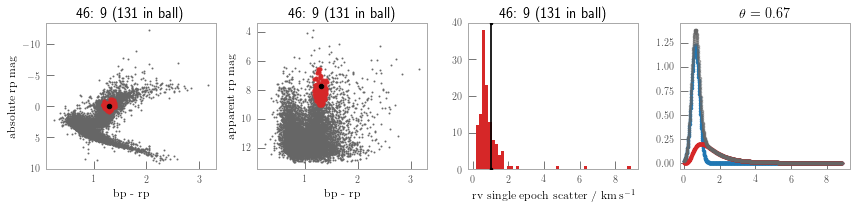

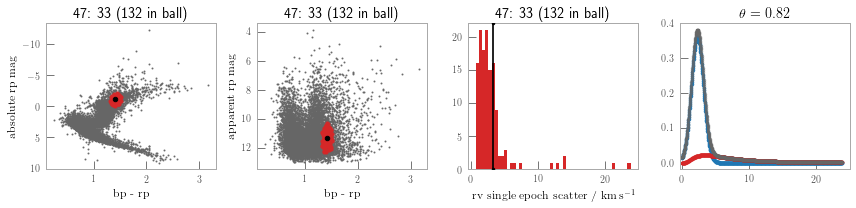

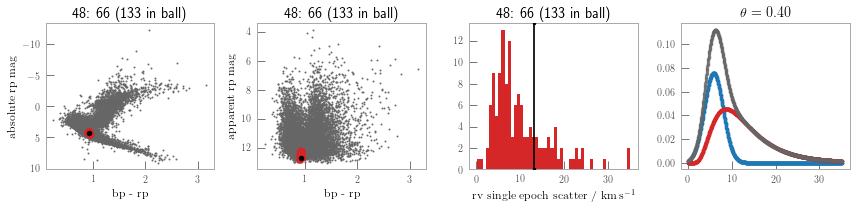

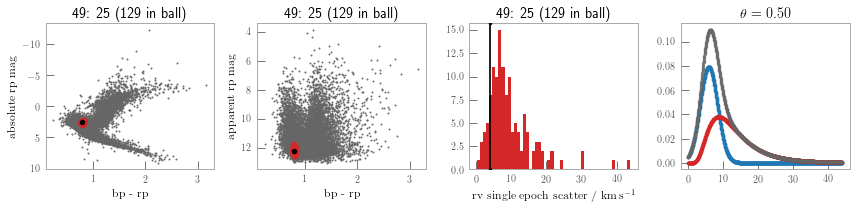

In [15]:
np.random.seed(42)

model = stan.load_stan_model(config["model_path"])

previous_opt = []

for i, index in enumerate(np.random.choice(N, P, replace=False)):
    
    K = 4
    fig, axes = plt.subplots(1, K, figsize=(3*K, 3))
    
    axes[0].scatter(X.T[0], X.T[1], **scatter_bg_kwds)
    
    nearby = npm.query_around_point(kdt, X[index], **query_kwds)
    axes[0].scatter(X[nearby, 0], X[nearby, 1], **scatter_ball_kwds)
    axes[0].scatter(X[[index], 0], X[[index], 1], **scatter_point_kwds)
    
    axes[0].set_xlabel(r"\textrm{bp - rp}")
    axes[0].set_ylabel(r"\textrm{absolute rp mag}")
    axes[0].set_ylim(axes[0].get_ylim()[::-1])
    
    axes[1].scatter(X.T[0], X.T[2], **scatter_bg_kwds)
    axes[1].scatter(X[nearby, 0], X[nearby, 2], **scatter_ball_kwds)
    axes[1].scatter(X[[index], 0], X[[index], 2], **scatter_point_kwds)
    axes[1].set_xlabel(r"\textrm{bp - rp}")
    axes[1].set_ylabel(r"\textrm{apparent rp mag}")
    axes[1].set_ylim(axes[1].get_ylim()[::-1])
    
    y = predictors[nearby].flatten()
    axes[2].hist(y[np.isfinite(y)], **hist_kwds)
    axes[2].axvline(predictors[index], **axvline_kwds)
    axes[2].set_xlabel(r"\textrm{rv single epoch scatter / km\,s$^{-1}$}")
    
    y = y.reshape(-1, 1)
    N, D = y.shape
    
    opt_kwds = dict(
        init=npm.get_initialization_point(y) if i == 0 else previous_opt[-1],
        verbose=False,
        tol_obj=7./3 - 4./3 - 1, # machine precision
        tol_grad=7./3 - 4./3 - 1, # machine precision
        tol_rel_grad=1e3,
        tol_rel_obj=1e4,
        iter=10000,
        data=dict(y=y, N=N, D=D))
    
    opt_kwds["init"]["theta"] = 0.75
    
    p_opt = model.optimizing(**opt_kwds)
    
    
    xi = np.linspace(0, y.max(), 1000)
    y1 = p_opt["theta"] * norm_pdf(xi, p_opt["mu_single"], p_opt["sigma_single"])
    y2 = (1 - p_opt["theta"]) * lognorm_pdf(xi, p_opt["mu_multiple"], p_opt["sigma_multiple"])
    axes[3].plot(xi, y1, c='tab:blue',)
    axes[3].plot(xi, y2, c='tab:red')
    axes[3].plot(xi, y1 + y2, c='#666666', alpha=0.5)
    axes[3].set_xlim(axes[2].get_xlim())
    axes[3].set_title(r"$\theta = {0:.2f}$".format(p_opt["theta"]))
    for ax in axes[:-1]:
        ax.set_title("{}: {} ({} in ball)".format(i, index, nearby.size))
    
    fig.tight_layout()
    
    for k in ("mu_single", "sigma_single", "mu_multiple", 
              "sigma_multiple", "mu_multiple_uv"):
        p_opt[k] = np.atleast_1d(p_opt[k])
    previous_opt.append(p_opt)

## THOUGHTS AND STRONG OPINIONS PLZ

In [16]:
# Rows 21 and 48 above are particularly worrying. 